https://www.kaggle.com/zhangyang/bldcv-sz512pad-0709

# params

In [1]:
dbg = False
if dbg:
    dbgsz = 500


PRFX = 'CV0712'    
p_o = f'../output/{PRFX}'
from pathlib import Path
Path(p_o).mkdir(exist_ok=True)


SEED = 111

BS = 32
SZ = 512
FP16 = False


from fastai.vision import *
params_tfms = {}

resize_method = ResizeMethod.PAD
padding_mode = 'zeros'

# setup

In [2]:
import fastai
print('fastai.__version__: ', fastai.__version__)

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

fastai.__version__:  1.0.54


# preprocess

In [3]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [4]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [5]:
p = '../input/diabetic-retinopathy-detection'
pp = Path(p)

train=pd.read_csv(pp/'trainLabels.csv')
img2grd_diab_train=[(f'../input/diabetic-retinopathy-detection/train_images/{o[0]}.jpeg',o[1])  for o in train.values]
img2grd += img2grd_diab_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'retinopathy_solution.csv')
img2grd_diab_test=[(f'../input/diabetic-retinopathy-detection/test_images/{o[0]}.jpeg',o[1])  for o in test.values]
img2grd += img2grd_diab_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())


38788

[(0, 27615), (2, 6291), (1, 2813), (3, 1066), (4, 1003)]

92364

[(0, 67148), (2, 14152), (1, 6575), (3, 2280), (4, 2209)]

In [6]:
p = '../input/IDRID/B. Disease Grading'
pp = Path(p)

train=pd.read_csv(pp/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
img2grd_idrid_train=[(f'../input/IDRID/B. Disease Grading/1. Original Images/a. Training Set/{o[0]}.jpg',o[1])  for o in train.values]
img2grd += img2grd_idrid_train
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

test=pd.read_csv(pp/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
img2grd_idrid_test=[(f'../input/IDRID/B. Disease Grading/1. Original Images/b. Testing Set/{o[0]}.jpg',o[1])  for o in test.values]
img2grd += img2grd_idrid_test
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

92777

[(0, 67282), (2, 14288), (1, 6595), (3, 2354), (4, 2258)]

92880

[(0, 67316), (2, 14320), (1, 6600), (3, 2373), (4, 2271)]

In [7]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [8]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(92880, 2)

In [9]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

if dbg:
    df=df.head(dbgsz)

# dataset

In [10]:
%%time
tfms = get_transforms(**params_tfms)

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz, 
                         resize_method=resize_method,
                         padding_mode=padding_mode) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 12.3 s, sys: 5.25 s, total: 17.6 s
Wall time: 13.2 s


CPU times: user 5.07 s, sys: 2.25 s, total: 7.32 s
Wall time: 48.8 s


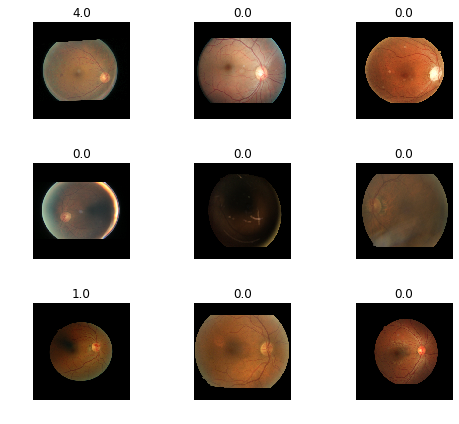

In [11]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [12]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

In [13]:
learn.freeze()

In [14]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 18.9 s, sys: 10.5 s, total: 29.4 s
Wall time: 4min 11s


Min numerical gradient: 1.00E-05
Min loss divided by 10: 8.32E-03


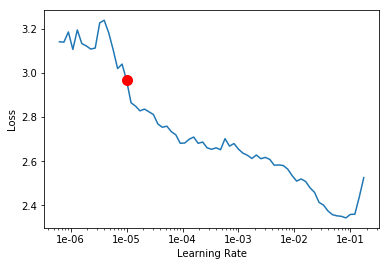

In [15]:
learn.recorder.plot(suggestion=True)

In [16]:
set_torch_seed()
learn.fit_one_cycle(10, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name=f'{PRFX}_model_frozen')])

epoch,train_loss,valid_loss,time
0,0.658998,0.574187,2:21:50
1,0.453384,0.405934,2:24:44
2,0.432086,0.378402,2:24:47
3,0.398741,0.348228,2:21:40
4,0.388693,0.466750,2:23:29
5,0.348721,0.313524,2:25:50
6,0.366078,0.314508,2:23:07
7,0.338230,0.348282,2:23:26
8,0.348399,0.362148,2:22:00
9,0.326901,0.502386,2:22:18


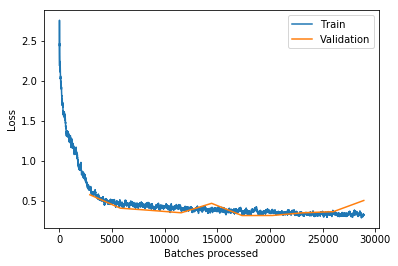

In [17]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [18]:
learn.save(f'{PRFX}_last_model_frozen')

In [19]:
!nvidia-smi

Sun Jul 14 03:44:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    48W / 300W |  15255MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [20]:
learn.unfreeze()

In [24]:
ls $p_o/models

CV0712_last_model_frozen.pth  CV0712_model_frozen_3.pth
CV0712_model_finetune_0.pth   CV0712_model_frozen_4.pth
CV0712_model_finetune_1.pth   CV0712_model_frozen_5.pth
CV0712_model_finetune_2.pth   CV0712_model_frozen_6.pth
CV0712_model_finetune_3.pth   CV0712_model_frozen_7.pth
CV0712_model_frozen_0.pth     CV0712_model_frozen_8.pth
CV0712_model_frozen_1.pth     CV0712_model_frozen_9.pth
CV0712_model_frozen_2.pth     tmp.pth


In [25]:
learn = learn.load('CV0712_model_frozen_6')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.20E-06
CPU times: user 22.9 s, sys: 11.9 s, total: 34.8 s
Wall time: 4min 36s


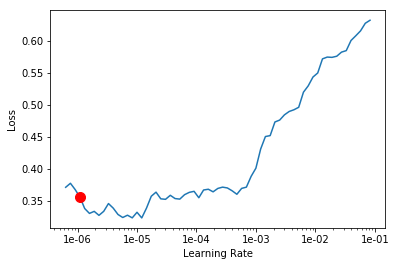

In [21]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
set_torch_seed()
learn.fit_one_cycle(5, max_lr=slice(1e-8,1e-6), callbacks=[SaveModelCallback(learn, every='epoch', name=f'{PRFX}_model_finetune')])

epoch,train_loss,valid_loss,time
0,0.345962,0.362707,2:22:47
1,0.340793,0.395737,2:22:58
2,0.343506,0.368282,2:22:01
3,0.330168,0.328694,2:24:13


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [ ]:
learn.save(f'{PRFX}_last_model_finetune')

In [ ]:
!nvidia-smi

# validate and thresholding

In [ ]:
learn = learn.load('bestmodel_finetune')

In [ ]:
learn = learn.to_fp32()

In [ ]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [ ]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [ ]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [ ]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

In [ ]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

In [ ]:
optnm2coefs

In [ ]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [ ]:
optnm2qwk

In [ ]:
Counter(y_val).most_common()

In [ ]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [ ]:
preds_val_grd.mean()

In [ ]:
Counter(preds_val_grd).most_common()

In [ ]:
list(zip(preds_val_grd, y_val))[:10]

In [ ]:
(preds_val_grd== y_val.squeeze()).mean()

In [ ]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

In [ ]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_val_grd = bucket(preds_val, coef)
    display(pd.Series(preds_val_grd.squeeze().astype(int)).value_counts())

# testing

In [ ]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

In [ ]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

In [ ]:
%%time
data.show_batch(rows=3, figsize=(7,6), ds_type=DatasetType.Test)

In [ ]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

In [ ]:
np.save(f'{p_o}/preds_tst.npy', preds_tst)

In [ ]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [ ]:
for optnm, coef in optnm2coefs.items():
    print(optnm, optnm2qwk[optnm], coef)
    preds_tst_grd = bucket(preds_tst, coef)
    display(pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts())

In [ ]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)
pd.Series(preds_tst_grd.squeeze().astype(int)).value_counts()


## submit

In [ ]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

In [ ]:
subm.diagnosis.value_counts()

In [ ]:
subm.to_csv(f"{p_o}/submission.csv", index=False)